In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

TensorFlow 2.x selected.


In [3]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [4]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 286 (delta 47), reused 272 (delta 35), pack-reused 0
Receiving objects: 100% (286/286), 13.38 MiB | 28.89 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  labels.append(1 if label == "7" else 0)

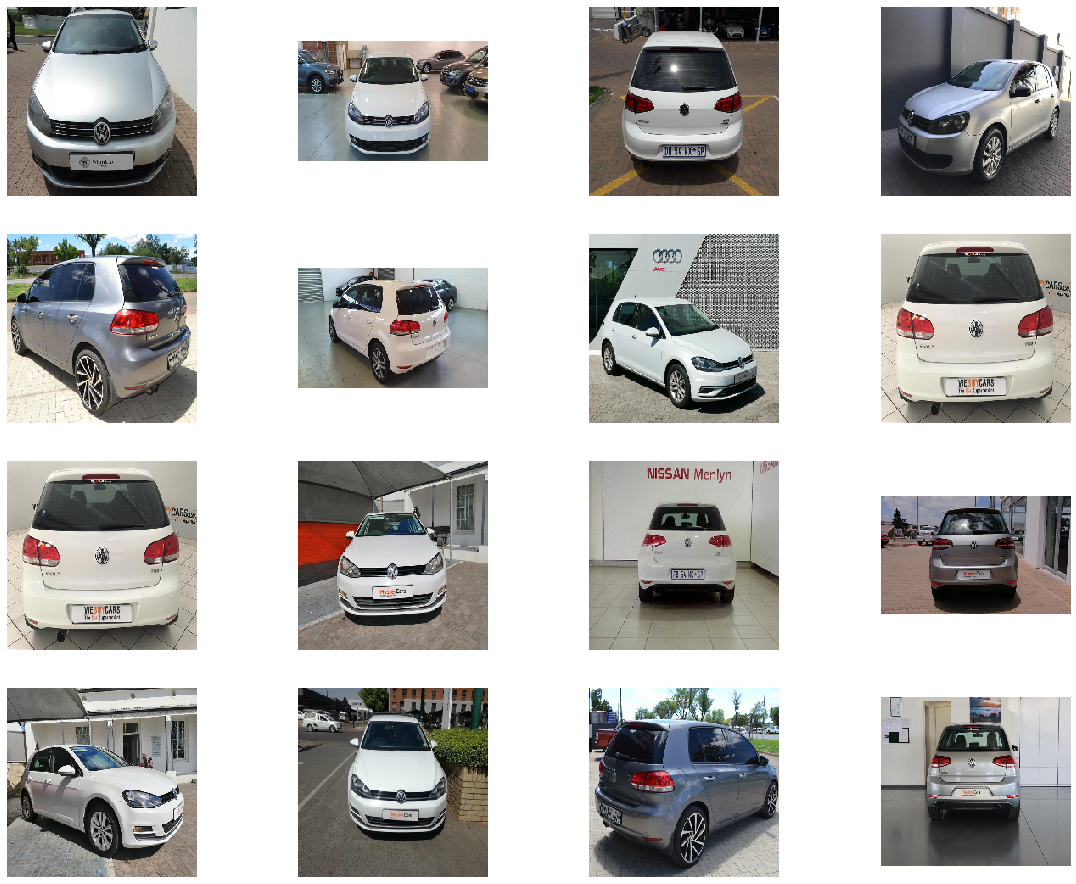

In [6]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

In [12]:
len(images)

688

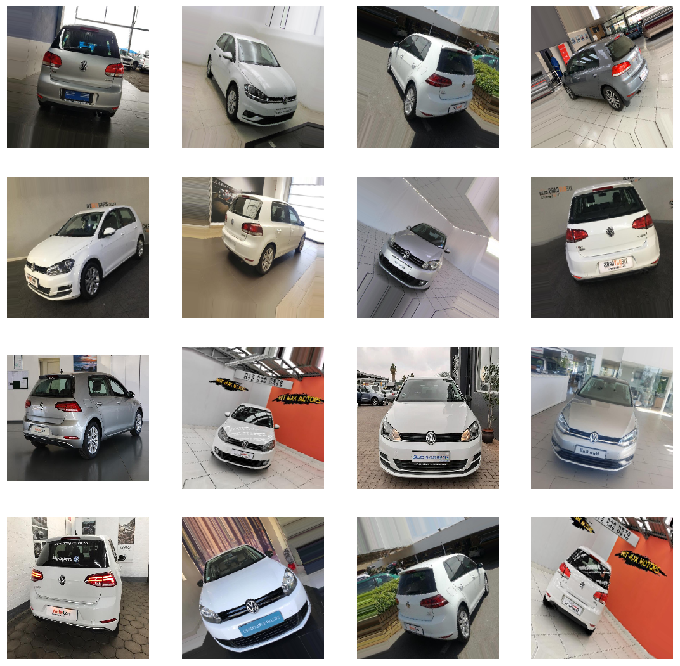

In [13]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labels = [[label] * REPLICATES for label in labels]
labels = [label for sublist in labels for label in sublist]

In [0]:
labels = np.array(labels)

In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size=0.2, random_state=13)

# Shallow CNN

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(20, kernel_size=5, activation = 'relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(50, kernel_size=5, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=2))      

model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation = 'softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 20)      1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 50)      25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 140450)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4494432   
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                1

In [0]:
batch_size = 32
epochs = 10

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Train on 440 samples, validate on 110 samples
Epoch 1/10
440/440 [==============================] - 4s 10ms/sample - loss: 1.1375 - accuracy: 0.5295 - val_loss: 1.4945 - val_accuracy: 0.6455
Epoch 2/10
440/440 [==============================] - 1s 3ms/sample - loss: 0.9086 - accuracy: 0.5886 - val_loss: 2.1643 - val_accuracy: 0.5818
Epoch 3/10
440/440 [==============================] - 1s 3ms/sample - loss: 0.7075 - accuracy: 0.6795 - val_loss: 1.0917 - val_accuracy: 0.6455
Epoch 4/10
440/440 [==============================] - 1s 3ms/sample - loss: 0.5969 - accuracy: 0.7273 - val_loss: 0.7542 - val_accuracy: 0.6273
Epoch 5/10
440/440 [==============================] - 1s 3ms/sample - loss: 0.4725 - accuracy: 0.7818 - val_loss: 0.7328 - val_accuracy: 0.6273
Epoch 6/10
440/440 [==============================] - 2s 4ms/sample - loss: 0.4719 - accuracy: 0.7909 - val_loss: 0.7529 - val_accuracy: 0.6273
Epoch 7/10
440/440 [==============================] - 1s 3ms/sample - loss: 0.4420 - accu

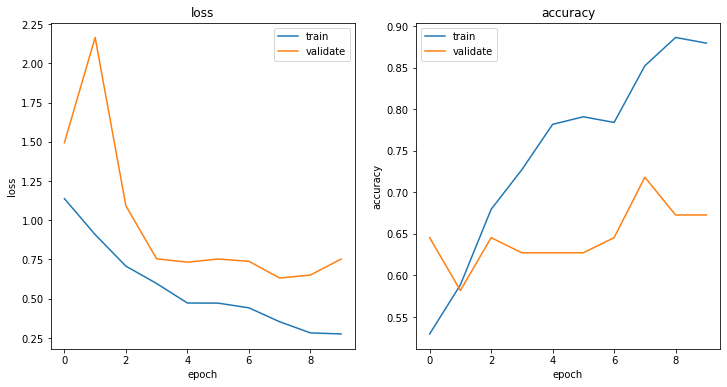

In [25]:
plot_history(history)

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 55.80% 
Test loss     = 0.887279


# Transfer learning

In [0]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [28]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 25,140,306
Non-trainable params: 53,152
_____________________________________

In [0]:
base_model.trainable = False

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 1,605,714
Non-trainable params: 23,587,744
__________________________________

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 440 samples, validate on 110 samples
Epoch 1/20
440/440 [==============================] - 11s 26ms/sample - loss: 0.9944 - accuracy: 0.5091 - val_loss: 1.0256 - val_accuracy: 0.5091
Epoch 2/20
440/440 [==============================] - 4s 10ms/sample - loss: 0.7622 - accuracy: 0.6432 - val_loss: 0.8612 - val_accuracy: 0.5545
Epoch 3/20
440/440 [==============================] - 4s 10ms/sample - loss: 0.5884 - accuracy: 0.6977 - val_loss: 0.7515 - val_accuracy: 0.5818
Epoch 4/20
440/440 [==============================] - 4s 10ms/sample - loss: 0.4892 - accuracy: 0.7705 - val_loss: 0.6712 - val_accuracy: 0.6364
Epoch 5/20
440/440 [==============================] - 4s 10ms/sample - loss: 0.4355 - accuracy: 0.8045 - val_loss: 0.6391 - val_accuracy: 0.6455
Epoch 6/20
440/440 [==============================] - 4s 10ms/sample - loss: 0.4104 - accuracy: 0.8341 - val_loss: 0.6136 - val_accuracy: 0.6636
Epoch 7/20
440/440 [==============================] - 4s 10ms/sample - loss: 0.3303

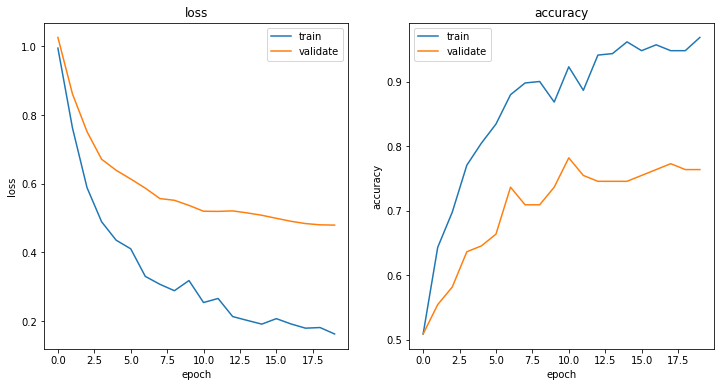

In [35]:
plot_history(history)

In [36]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 70.29% 
Test loss     = 0.509971


# Fine tune ResNet50

In [37]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [0]:
# base_model.summary()

In [39]:
def trainable_weights(model):
  return sum([int(tf.size(weights)) for weights in model.trainable_weights])

# How many trainable weights in the base model?
trainable_weights(base_model)

0

In [40]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

23534592

In [41]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[171:174]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

1054720

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 2,660,434
Non-trainable params: 22,533,024
__________________________________

In [44]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=5,
    verbose=1,
    validation_split=0.2
)

Train on 440 samples, validate on 110 samples
Epoch 1/5
440/440 [==============================] - 9s 21ms/sample - loss: 0.1636 - accuracy: 0.9659 - val_loss: 0.4711 - val_accuracy: 0.7818
Epoch 2/5
440/440 [==============================] - 4s 10ms/sample - loss: 0.1674 - accuracy: 0.9682 - val_loss: 0.5009 - val_accuracy: 0.7455
Epoch 3/5
440/440 [==============================] - 4s 10ms/sample - loss: 0.1293 - accuracy: 0.9773 - val_loss: 0.4662 - val_accuracy: 0.7909
Epoch 4/5
440/440 [==============================] - 4s 10ms/sample - loss: 0.1403 - accuracy: 0.9750 - val_loss: 0.4606 - val_accuracy: 0.8000
Epoch 5/5
440/440 [==============================] - 4s 10ms/sample - loss: 0.1458 - accuracy: 0.9659 - val_loss: 0.4623 - val_accuracy: 0.7909


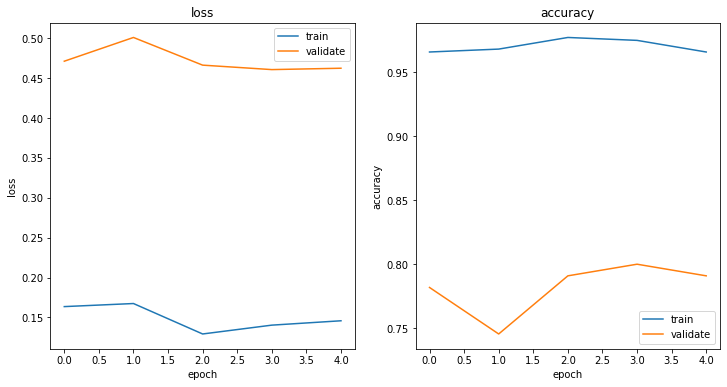

In [45]:
plot_history(history)

In [46]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 73.91% 
Test loss     = 0.504529


# Transfer learning with less complex architechture - VGG16

In [47]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                401424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 15,116,210
Trainable params: 15,116,178
Non-trainable params: 32
_________________________________________

In [0]:
base_model.trainable = False

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                401424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 15,116,210
Trainable params: 401,490
Non-trainable params: 14,714,720
____________________________________

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 440 samples, validate on 110 samples
Epoch 1/50
440/440 [==============================] - 14s 31ms/sample - loss: 1.3007 - accuracy: 0.5068 - val_loss: 2.4563 - val_accuracy: 0.4909
Epoch 2/50
440/440 [==============================] - 5s 12ms/sample - loss: 1.3217 - accuracy: 0.5523 - val_loss: 1.8024 - val_accuracy: 0.4818
Epoch 3/50
440/440 [==============================] - 5s 12ms/sample - loss: 1.0715 - accuracy: 0.5818 - val_loss: 1.5111 - val_accuracy: 0.4818
Epoch 4/50
440/440 [==============================] - 5s 12ms/sample - loss: 1.0437 - accuracy: 0.5659 - val_loss: 1.3205 - val_accuracy: 0.5091
Epoch 5/50
440/440 [==============================] - 5s 12ms/sample - loss: 0.9611 - accuracy: 0.5909 - val_loss: 1.1846 - val_accuracy: 0.5273
Epoch 6/50
440/440 [==============================] - 5s 12ms/sample - loss: 0.9019 - accuracy: 0.6159 - val_loss: 1.0787 - val_accuracy: 0.5727
Epoch 7/50
440/440 [==============================] - 5s 12ms/sample - loss: 0.9337

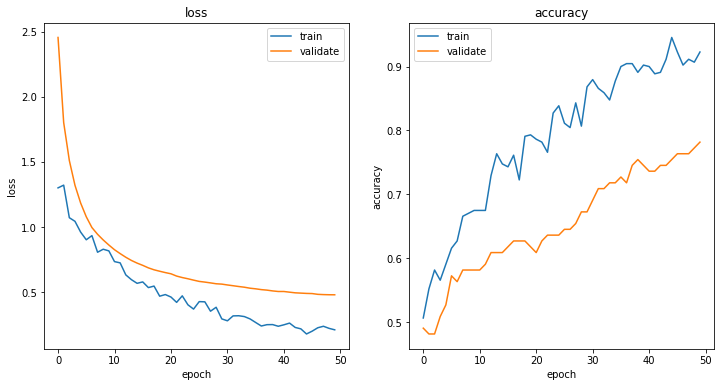

In [54]:
plot_history(history)

In [55]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 73.91% 
Test loss     = 0.511813


# Fine tune VGG16

In [56]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [57]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [58]:
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)

14714688

In [59]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

14714688

In [60]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[15:18]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

7079424

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                401424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 15,116,210
Trainable params: 7,480,914
Non-trainable params: 7,635,296
___________________________________

In [63]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1,
    verbose=1,
    validation_split=0.2
)

Train on 440 samples, validate on 110 samples
440/440 [==============================] - 7s 17ms/sample - loss: 0.2214 - accuracy: 0.9023 - val_loss: 0.4472 - val_accuracy: 0.8182


In [64]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 78.26% 
Test loss     = 0.491432


In [65]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=5,
    verbose=1,
    validation_split=0.2
)

Train on 440 samples, validate on 110 samples
Epoch 1/5
440/440 [==============================] - 6s 13ms/sample - loss: 0.2010 - accuracy: 0.9205 - val_loss: 0.3964 - val_accuracy: 0.8545
Epoch 2/5
440/440 [==============================] - 6s 13ms/sample - loss: 0.1686 - accuracy: 0.9455 - val_loss: 0.3780 - val_accuracy: 0.8364
Epoch 3/5
440/440 [==============================] - 6s 13ms/sample - loss: 0.1324 - accuracy: 0.9614 - val_loss: 0.3783 - val_accuracy: 0.8455
Epoch 4/5
440/440 [==============================] - 6s 13ms/sample - loss: 0.1234 - accuracy: 0.9568 - val_loss: 0.3798 - val_accuracy: 0.8636
Epoch 5/5
440/440 [==============================] - 6s 13ms/sample - loss: 0.1385 - accuracy: 0.9614 - val_loss: 0.3883 - val_accuracy: 0.8364


In [66]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 81.88% 
Test loss     = 0.388521


# Unseen data

In [0]:
def classify(img_url, class_type):
  response = requests.get(img_url)
  if response.status_code == 200:
    if(class_type == '6'):
      os.chdir('car-dataset/train/6')
      filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)
    else:
      os.chdir('car-dataset/train/7')
      filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)
    with open('{}.jpg'.format(filename), 'wb') as f:
        f.write(response.content)
        
  img = image.load_img('{}.jpg'.format(filename), target_size=(224, 224))
  os.chdir('../../..')
  plt.imshow(np.squeeze(img).astype('uint8'))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  print(('7' if (model.predict_classes(img) == 1) else '6'),  model.predict_proba(img))

## Golf 6

6 [[0.98381084 0.01618916]]


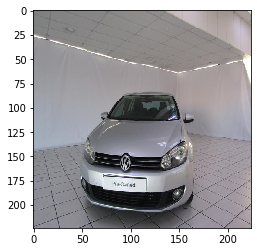

In [68]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6'
)

6 [[9.9953187e-01 4.6817947e-04]]


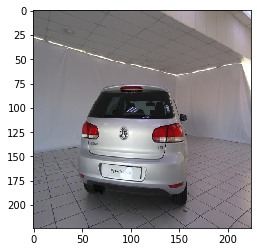

In [69]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6'
)

6 [[0.9955102  0.00448981]]


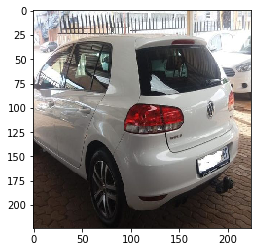

In [70]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6'
)

6 [[0.985213   0.01478697]]


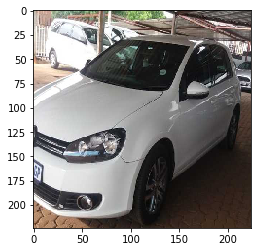

In [71]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6'
)

7 [[0.2426624  0.75733757]]


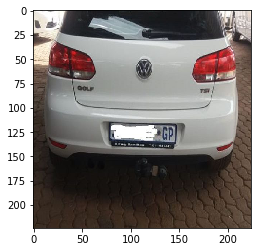

In [72]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6'
)

6 [[0.775156   0.22484402]]


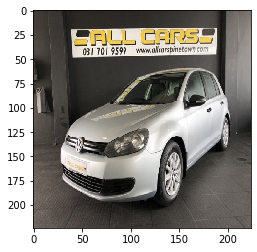

In [73]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6'
)

6 [[0.6964252  0.30357477]]


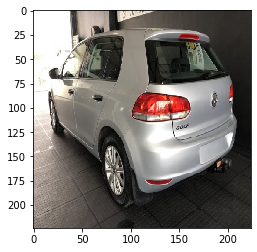

In [74]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6'
)

6 [[0.98787886 0.01212109]]


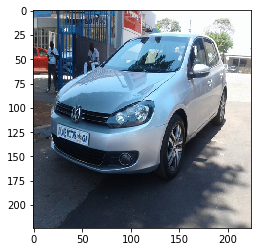

In [75]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6'
)

6 [[9.9929345e-01 7.0658233e-04]]


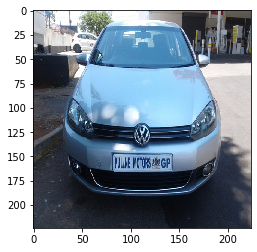

In [76]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6'
)

6 [[0.93034196 0.06965805]]


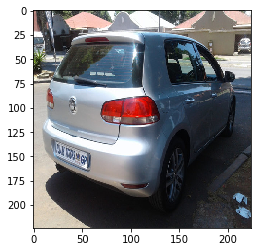

In [77]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6'
)

6 [[0.80310094 0.19689907]]


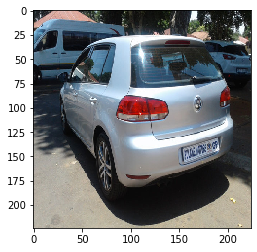

In [78]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6'
)

7 [[0.01587772 0.9841223 ]]


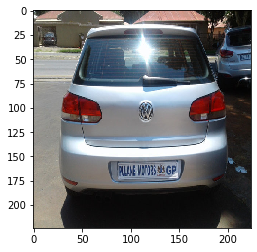

In [79]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6'
)

6 [[0.78142583 0.2185742 ]]


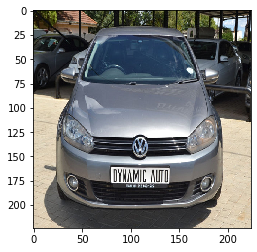

In [80]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6'
)

## Golf 7


7 [[0.03927231 0.9607277 ]]


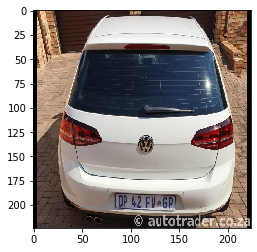

In [81]:
classify(
    'https://img.autotrader.co.za/4790868/Crop800x600',
    '7'
)